In [1]:
# existing imports
from dataclasses import dataclass
import sys
from tqdm import tqdm
# third party imports
import scipy.integrate as integrate
import scipy.sparse as sparse
import scipy.linalg
import numpy as np
np.random.seed(101101)
# local imports
sys.path.insert(0,'..')
from src.matrices import get_J_matrix
# display imports
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import Video

<h1>02-Simulate Evolution of Neural System</h1>
Now we are going to take the matrices for J and H generated previously, and use them as update values to a differential equation. Parameters pulled from last notebook for simulation here.

In [2]:
parameters = [{'u'    :0.5
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :0.0
              ,'gamma':0.0}
              
             ,{'u'    :0.0
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}
              
             ,{'u'    :0.5
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}
              
             ,{'u'    :0.5
              ,'w'    :0.5
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}]

N = 200
u, w, alpha, beta, gamma = parameters[2].values()
matrix = get_J_matrix(N,**parameters[2])

<h2>Eigenvalues and Eigenvectors</h2>
Looking at the greatest eigenvalues and vectors of the matrix in our differential equation will give us an understanding the stable states of the neural system

In [3]:
lambs, vecs = scipy.linalg.eig(np.array(matrix))

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<h2>Define Differential Equation</h2>
Here we define the differential equation as defined in Tanaka et al. equation (8)
$$
  \tau \frac{dr_i}{dt} = -r_i(t) + f[\sum_j J_{i j} r_j(t) + h_i(t)]
$$
where f is the neurons activation function, and h_i is the ith neurons external input.

In [5]:
@dataclass
class NeuronDiffEq:
    matrix: np.matrix
    tau: np.double
    N: int
    
    def activation(self,x):
        '''
            Activation function on neurons that take sum of inputs
        '''
        out = np.zeros(x.shape)
        out[(x + 1) < 0]  = 0.0
        out[(x + 1) >= 0] = x[(x + 1) >= 0] + 1
        return out
    
    def external(self,t):
        '''
            External input to each neuron at time, t
        '''
        
        return 0.0
    
    def __call__(self,r,t):
        '''
            THE EQUATION
        '''
        interactions = np.array(self.matrix @ r).squeeze()
        out = (-r + self.activation(interactions + self.external(t)).squeeze())/self.tau
        return out

Now we can use our class format to have children with different external inputs

In [6]:
@dataclass
class NoisyNeuron(NeuronDiffEq):
    mu: np.double
    sigma: np.double
    
    def external(self,t):
        
        out = np.random.normal(self.mu,self.sigma,self.N)
        return out

@dataclass
class ConstantInput(NeuronDiffEq):
    constant: np.double
    sites: slice
    
    def external(self,t):
        
        out = np.zeros(self.N)
        out[self.sites] = self.constant
        return out

<h2>Simulation Time</h2>
Now we are going to simulate the neurons as connected by the above matrix.

In [13]:
tau = 5
tspace = range(100)
r0 = np.zeros(N)
r0[:N//2] = 3.0
in_array = np.zeros((len(tspace),*r0.shape))

mu = 0.0
sigma = 10.0
constant = 3.0
sites = slice(0,N//3)
# neurons = NoisyNeuron(matrix,tau,N,mu,sigma)
# neurons = ConstantInput(matrix,tau,N,constant,sites)
neurons = NeuronDiffEq(matrix,tau,N)
results = integrate.odeint(neurons,r0,tspace)

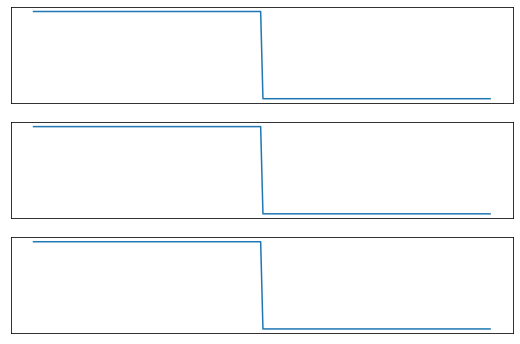

In [14]:
n_imgs = 3
strt_img = 0

fig, axs = plt.subplots(n_imgs,figsize=(3*n_imgs,6))
# metrics = np.zeros((len(kernels),*image.shape))
for index,img_i in enumerate(range(strt_img,n_imgs+strt_img)):

    axs[index].plot(results[img_i,...])
    axs[index].set_xticks([])
    axs[index].set_yticks([])
        
plt.show()

Reorder of eigenvectors by largest values. And selecting some to plot.

In [15]:
eig_n = 10
ordered_inds = np.argsort(lambs.real)
vecs_sp = vecs[:,ordered_inds[:eig_n]]

In [16]:
vecs_sp.shape

(200, 10)

script to write a movie of the neural state evolving over time.

102it [00:07, 14.16it/s]                         


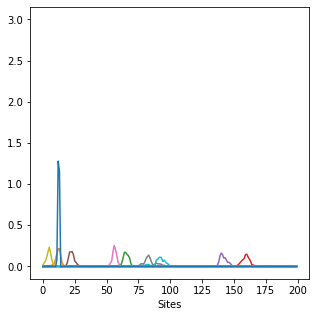

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

for iii in range(eig_n):
    ax.plot(np.abs(vecs_sp[:,iii])**2)

line, = ax.plot(results[0,...])
# ax.axis('equal')
ax.set_xlabel('Sites')


orders = np.arange(0,len(tspace),dtype=int)
with tqdm(total=len(tspace)) as pbar:
        
    def next_image(index):
        
        line.set_ydata(results[index,...])
#         ax.set_title("{}".format(tim_stack[index]))
        pbar.update(1)
        
        return line,
            
    ani = animation.FuncAnimation(
        fig,
        next_image,
        frames=orders,
        interval=200,
        repeat=False,
        repeat_delay=100,
        blit=True
    )
#     plt.show()
    filename = "out/diffeqJ_u{}_w{}_a{}_b{}_g{}.mp4".format(u,w,alpha,beta,gamma)
    ani.save(filename)

In [12]:
Video(filename)